# Homework 5: Adversarial Sample Generation and Defense
Designed for EN.601.743

Due date: 02-21-2019 11:59

Submit to email [zzhen1@jhu.edu](mailto:zzhen1@jhu.edu)


## Submission instructions
All code snippets and writeup should be placed in this file. After finishing work, please change the file name with format `<your-name>_hw5.ipynb` and send via email with the subject as "*Adv Topic in Security and Privacy Homework 5*". Thanks! (No need to include `model` file or `data` files)

## Structure of this homework
The homework consist of two sections, implementation (15 points) and writeup (5 points).
### Implementation
Implementation has been divided into four parts: 
0. open the ipython notebook (1 point)
1. print the image you choose for adversarial attack (2 points)
2. complete the adversarial attacking procedure with given attacking function (5 points)
3. try different parameter for the attack (2 points)
4. implement feature sequeezing function (5 points)

**Note**: `# <your implementation>` has been used to mark the implementation place.

Detailed explainations are given at each code snippet you need to complete. Implementations are using `python` and `pytorch`. If you need instructions for `pytorch` installation please follow [here](https://pytorch.org/get-started/locally/). If you need further assitant, feel free to contact [me](mailto:zhen@jh.edu). Code snippets of adversarial attacking parts are mainly borrow from [pytorch-adversarial-example-generation](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html), so you can take it as a reference. But please remember things a little different here that we want to attack on one sample until we success. 

### Writeup
(Write your thoughts at last input box)

How machine learning will change the field you are working on? And how adversarial machine learning can affect your research area?


# ------------------ splitting --------------------

In [1]:
# -------------- following contents are fixed ---------------
# you have to run this to ensure needed packages are included

%matplotlib inline
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# define trained model path
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True
# MNIST Test dataset and dataloader declaration
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))
test_loader = torch.utils.data.DataLoader(test_dataset, 
        batch_size=1, shuffle=False)

# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# -------------- ends preparation ---------------

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

#### Implementation: 1) plot image data
Using `matplotlib` to complete the function `plot_img`. The package has been imported as `plt` Test with selected index of a test image. (HINT: using `imshow` function)

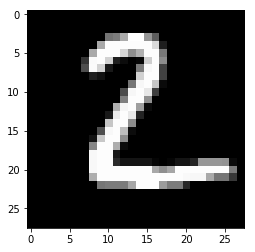

In [2]:
def plot_img(image):
    """
    :param image: m x m matrix, assume in gray scale
    """
    # fill your implementation here
    # <your implementation>
    # end the implementation

idx = 1 # test with different index
image = test_dataset[idx][0].squeeze() # don't need to modify this
plot_img(image)

#### Implementation: 2) Complete attacking loop
The goal is to get an adversarial sample for selected image. 
Not all images can have adversary samples.
Thus, the attacking loop should go `max_try` as maximum attacking try. 
After `max_try` times attacking, if we still have not found an adversary, we need to 
choose another image for experiment. 

procedure inside the attacking loop goes following:    
1) get the output from model with the input image.   
2) obtain the loss from output and label, using function `F.nll_loss`    
3) using `backward` function of obtained loss to compute gradients, before `backward` operation using `model.zero_grad()` function first, to clean up gradients computed last round.    
4) obtain gradients for the input image, via `img_grad = img.grad.data`     
5) using input image, gradients of image and epsilon as inputs to `fgsm_attack` function to generate a `modified image`.     
6) get output of `modified image` with model, and get the prediction     
7) if the prediction on `modified image` changes, attacking ends. otherwise using the `modified image` as base image try again.     
8) once found the adversary sample, remember to print it with first function implemented `plot_img`.     

**note**: for step 7, it is tricky to assign modified image as origin image for next round, using follow code for assignment: 
```
img = torch.tensor(modified_image.data)
img.requires_grad = True
```    
For step 8, using `modified_image.squeeze().detach()` to get the image data for printing.

In [29]:
# valid img_idx: 0-9999
img_idx = 200 # put the idx of the image, which an adversarial image will be generated for it
epsilon = 0.05 # the hyper parameter to control how large the perturbation on the original image
max_try = 5000 # the maximiun steps that algorithm should try 

# data preparation; 
img, label = test_dataset[img_idx][0].to(device), test_dataset[img_idx][1].to(device)
img = img.unsqueeze(0) 
label = label.unsqueeze(0) 
# end data preparation 

# setup the image tensor to require gradient computation
img.requires_grad = True
output = model(img) # obtain model output, it is a softmax distribution for each label
prediction = output.max(1, keepdim=True)[1] # get the largest one as final prediction

if prediction.item() != label.item():
    print('model makes mistake for selected sample, choose another one')
else:
    # !! start attacking
    # start you implementation
    # <your implementation>
    # end the implementation

#### Implementation: try differernt epsilon at last section
Try different `epsilon` values at the previous code block. You should see different outputs. Please conclude what you observed. [Differences in adversarial images, and number of tried steps]

In [31]:
# <your implementation> : conclusion of observation


#### Implementation: defense adversary attack with feature squeezing
Previous attacking methods add noise on the origin image to generate adversarial. One way to defend against such attacking is *denoising the input image*. In this section, you need to implement the `denoising_func` to accomplish the image data preprocessing, so that the model can produce right prediction result as expected.

One way to denoise the image is `feature squeezing`[1]. The main idea is to reduce the precision of the input image. For example, a pixel value in the image is *0.875*(224 scaled to [0,1]), after rounding the value become *1.0*. 

Referring [this file](https://github.com/mzweilin/EvadeML-Zoo/blob/master/utils/squeeze.py) for function implementation.

[1] Xu, Weilin, David Evans, and Yanjun Qi. "Feature squeezing: Detecting adversarial examples in deep neural networks." arXiv preprint arXiv:1704.01155 (2017).

In [ ]:
def denoising_func(image):
    """ 
    :param image: is a numpy array
    """
    # <your implementation>
    
# testing with modified image obtained in previous sections
denoised_img = denoising_func(modified_image.squeeze().detach().cpu().numpy())
denoised_img = torch.tensor(denoised_img).unsqueeze(0).unsqueeze(0)
denoised_output = model(denoised_img)
denoised_pred = denoised_output.max(1, keepdim=True)[1]
print('ground truth label', label.item())
print('prediction on denoised image', denoised_pred.item())

### Writeup

1. How machine learning will change the field you are working on? 

2. How adversarial machine learning can affect your research area?

In [ ]:
# <your writeup>